## design leader sequence

In [2]:
import infrared as ir
import infrared.rna as rna
import RNA
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_617654/185338957.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def remove_positioned_gaps(sequence, structure):
    remove = [i for i, nt in enumerate(sequence) if nt == '-']
    new_ss = [structure[i] for i in range(len(structure)) if i not in remove]
    return ''.join(new_ss)

In [104]:
design_09 =   'CCGCCCAG-G-GCCUA-GGCAGCACGC--GAAAUUAG---GCGACGGGA--GA--GGGUCGGA--UCCCGAC-UGGGCAG-CUGGGCAAUUUGUAA----UUUGUGAGACCC'
a =           "NNNNNNNNXXXNNNNXXGGCAGCRCRCXXNNNXXXXXXXXGYGACGGGXXXXXXXXGGUCXXXXXXCCCGACXXNNNNXXXNNNNNNNNNNNNXXXXXXXUUYGUGAXGACC"
structures = ['..(((((((..(((((((......(((((.........))))).(((((((............))))))).)))))))..))))))).........................',
		      '.....................(((..............................................................................))).......',
		      '.......................................................(((((...............................................)))))']
 
xrRNA_ss = [remove_positioned_gaps(design_09, ss) for ss in structures]
xrRNA_seq = design_09.replace('-','')
print(xrRNA_seq)
for i in xrRNA_ss: print(i)

CCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
..((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................
..................(((.............................................................))).......
...........................................(((((.......................................)))))


In [6]:
extended_iupac_nucleotides = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'U': 'U',
    'R': 'AG',
    'N': 'ACGU',
    'X': 'ACGU-',
    '-': '-',
    '.': '-'
}


def iupacvalues(symbol):
    return [ rna.nucleotide_to_value(x) for x in extended_iupac_nucleotides[symbol] ]

def sample_to_seq(sample):
    return rna.values_to_seq(sample.values())

def calculate_gc(seq):
    seq = seq.upper()
    return (seq.count('G') + seq.count('C')) / len(seq)

In [47]:
## GCUAA stays unpaired
target_leader =         ".........((((((....))))))...."
iupac_sequence = 'GCUAANNNXNNNNNXNNNXXNNNNNNNXX'
n = len(target_leader)
model = ir.Model()
model.add_variables(n, 5)

for i, x in enumerate(iupac_sequence):
    model.add_constraints(ir.ValueIn(i, iupacvalues(x)))

model.add_constraints(rna.BPComp(i,j) for (i,j) in rna.parse(target_leader))
model.add_functions([rna.GCCont(i) for i in range(n)], 'gc')

sampler = ir.Sampler(model)
# samples = [sample_to_seq(sampler.sample()) for _ in range(10000)]
sampler.set_target( 0.5 * n, 0.1 * n, 'gc' )
samples = [sample_to_seq(sampler.targeted_sample()) for _ in tqdm(range(10000))]

100%|██████████| 10000/10000 [00:01<00:00, 9836.87it/s]


In [48]:
def target_frequency(sequence, ss):
    fc = RNA.fold_compound(sequence.replace('-',''))
    fc.pf()
    return fc.pr_structure(ss)

def acceptable_seq(seq, ss):
    if not ss.startswith('........'):
        return False
    return True

In [49]:
ok_leader= []
for seq in tqdm(samples):
    seq_ = seq.replace('-','')
    fc  = RNA.fold_compound(seq_)
    (ss, mfe) = fc.mfe()
    if acceptable_seq(seq_, ss):
        ok_leader.append(seq)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4634.38it/s]


In [50]:
len(ok_leader)

4102

In [51]:
def test_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss):
    target_ss = remove_positioned_gaps(leader_seq, target)
    target_ss = target_ss + xrRNA_ss


    seq = leader_seq.replace('-','') + xrRNA_seq

    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    strikes = 0
    for s in fc.subopt(500):
        if s.structure[len(leader_seq):] != xrRNA_ss or not s.structure.startswith('.....'):
            return False
    return True

In [62]:
def print_suboptimal_ss(leader_seq, xrRNA_seq, xrRNA_ss, sample_size=1000):
    ss_leader = remove_positioned_gaps(leader_seq, target)
    target_ss = ss_leader + xrRNA_ss

    seq = leader_seq.replace('-','') + xrRNA_seq
    
    fc = RNA.fold_compound(seq)
    (ss, mfe) = fc.mfe()
    suboptimal_ss = []
    for s in fc.subopt(sample_size):
        if s.structure not in suboptimal_ss:
            print(seq)
            print(f"{s.structure}\t{s.energy:6.2f}")
            print(f'{"-" * len(ss_leader) + "+" * len(xrRNA_seq)}\n')
            suboptimal_ss.append(s.structure)
    return True

In [53]:
def test_interaction(leader_seq, xrRNA_seq, xrRNA_ss,threshold = 0.01):
    leader_seq = leader_seq.replace('-','')

    seq = leader_seq + xrRNA_seq
    fold_compound = RNA.fold_compound(seq)
    fold_compound.pf()
    base_pair_probs = np.array(fold_compound.bpp())
    for i in range(len(leader_seq)):
        for j in range(len(leader_seq), len(seq)):
            if base_pair_probs[i][j] > threshold:  # Adjust threshold as needed
                return False
    return True

In [54]:
good_candidates = []

for seq in tqdm(ok_leader):
    if test_interaction(seq, xrRNA_seq, xrRNA_ss[0], 0.05):
        good_candidates.append(seq)



100%|██████████| 4102/4102 [01:40<00:00, 40.93it/s]


In [55]:
len(good_candidates)

29

In [56]:
best_seq = None
best_freq = 0
for seq in tqdm(ok_leader):
    target_ss = remove_positioned_gaps(seq, target_leader)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))
print(best_seq)

  0%|          | 0/4102 [00:00<?, ?it/s]

  0%|          | 3/4102 [00:00<03:04, 22.28it/s]

0.07
0.09


  0%|          | 12/4102 [00:00<02:01, 33.55it/s]

0.24


  3%|▎         | 121/4102 [00:03<01:36, 41.45it/s]

0.24


  3%|▎         | 135/4102 [00:03<01:45, 37.66it/s]

0.26


  6%|▋         | 257/4102 [00:06<01:30, 42.55it/s]

0.42


 17%|█▋        | 715/4102 [00:16<01:19, 42.75it/s]

0.43


 22%|██▏       | 909/4102 [00:21<01:11, 44.43it/s]

0.5


100%|██████████| 4102/4102 [01:37<00:00, 41.90it/s]


In [59]:
best_seq = None
best_freq = 0
for seq in tqdm(good_candidates):
    target_ss = remove_positioned_gaps(seq, target_leader)
    target_ss += xrRNA_ss[0]
    
    whole_seq = seq + xrRNA_seq
    cur_freq = target_frequency(whole_seq, target_ss)
    if cur_freq > best_freq:
        best_freq = cur_freq
        best_seq = seq
        print(round(target_frequency(whole_seq, target_ss), 2))

print(best_seq)

 41%|████▏     | 12/29 [00:00<00:00, 40.18it/s]

0.42
0.5


100%|██████████| 29/29 [00:00<00:00, 42.03it/s]

GCUAAACUAGGAGGGGAAACCCUCCAUCC


In [73]:
good_candidates_stored = ['GCUAAAAC-CAUAGCCGUAGCUAUGAU-C', 'GCUAAACUAGGAGGGGAAACCCUCCAUCC','GCUAAAGA-GCUUGCGUAAAGCAAGCAA--']

In [70]:
best_seq = 'GCUAAACUAGGAGGGGAAACCCUCCAUCC'

In [76]:
print_suboptimal_ss(good_candidates_stored[2], xrRNA_seq, xrRNA_ss[0], 400)


GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................	-42.50
---------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((.....))))))....((((((.((((((......(((........))).(((((..(...)...))))).))))))..)))))).....................	-41.30
---------------------------++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((.....))))))....((((((.((((((......(((........))).(((((((...))...))))).))))))..)))))).....................	-40.60
-----------------

True

In [83]:
best_seq = good_candidates_stored[2]

GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC
........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... (-42.50)
........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... [-42.92]
........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... {-42.50 d=1.51}
........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..))))))..................... {-42.50 MEA=116.26}
 frequency of mfe structure in ensemble 0.507905; ensemble diversity 2.95  



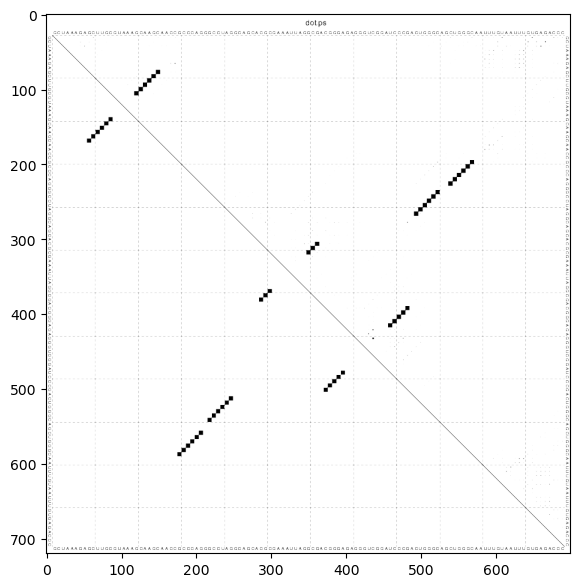

In [87]:
seq = best_seq.replace('-', '') + xrRNA_seq
!echo $seq > test.seq
!RNAfold -p --MEA < test.seq
!convert dot.ps dot.png

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image = mpimg.imread("dot.png")
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC', '-structureDBN', '........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................', '-o', '/tmp/tmp4r29rj2a.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#0000ff', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#ff0000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119']


Output file: /tmp/tmp4r29rj2a.png



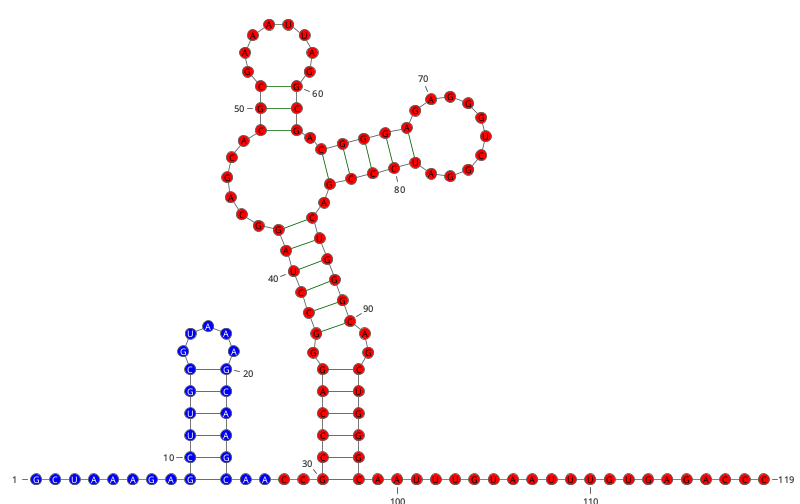

['java', '-cp', '/home/mescalin/kgutenbrunner/Downloads/VARNAv3-93.jar', 'fr.orsay.lri.varna.applications.VARNAcmd', '-sequenceDBN', 'GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC', '-structureDBN', '........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................', '-o', '/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png', '-bp', '#006400', '-resolution', '2.0', '-bpStyle', 'simple', '-basesStyle1', 'fill=#0000ff', '-applyBasesStyle1on', '1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27', '-basesStyle2', 'fill=#ff0000', '-applyBasesStyle2on', '28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,1

Output file: /scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png



In [110]:
from varnaapi import Structure
import varnaapi
seq =  'GCUAAAGAGCUUGCGUAAAGCAAGCAACCGCCCAGGGCCUAGGCAGCACGCGAAAUUAGGCGACGGGAGAGGGUCGGAUCCCGACUGGGCAGCUGGGCAAUUUGUAAUUUGUGAGACCC'
ss =  r'........((((((.....))))))....((((((.((((((...{{{(((........))).(((((..[[[[[...))))).))))))..))))))...........}}}..]]]]]'
ss =  r'........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................'

v = varnaapi.Structure(sequence=seq, structure=ss)
# .update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)


v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)
style_leader = varnaapi.param.BasesStyle(fill="blue")
style_xrRNA = varnaapi.param.BasesStyle(fill="red")

v.add_bases_style(style_leader, list(range(1,28)))
v.add_bases_style(style_xrRNA, list(range(28,len(ss)+1)))

v.update(bpStyle='simple', drawBackbone=True, bp='#006400', fillBases=True, spaceBetweenBases=1, resolution=2)

v.show()
v.savefig('/scr/aldea/kgutenbrunner/working/xrRNA_design/MBFV_design/leader_design/structure.png')


In [105]:
print('........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................')
print('...........................' + xrRNA_ss[1])
print('...........................' + xrRNA_ss[2])

........((((((.....))))))....((((((.((((((......(((........))).(((((..........))))).))))))..)))))).....................
.............................................(((.............................................................))).......
......................................................................(((((.......................................)))))
